In [ ]:
!pip install -q sentence-transformers
!pip install -q umap-learn

In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from scipy import spatial
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import umap
from sentence_transformers import SentenceTransformer
from bs4 import BeautifulSoup
from datetime import datetime

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/NYU-Tandon_Bridge/"
# Import raw json data
#with open(path+"'Piazza Data'/'Summer 2020 (24 Weeks)'/piazza_posts_data.csv", "r") as f:
#    raw_transcript = json.load(f)
df_posts = pd.read_csv('/content/drive/MyDrive/NYU-Tandon_Bridge/Piazza_Data/piazza_posts_data.csv')
df_followups = pd.read_csv('/content/drive/MyDrive/NYU-Tandon_Bridge/Piazza_Data/piazza_followups_data.csv')

In [ ]:
df_posts['type'] = 'post'

In [ ]:
df_posts.head()

,Unnamed: 0,anon,uid,subject,created,content,post_id,is_instructor,uid_a,unique_id,length,length_cont,length_subj,type
0,0,no,jqjrav14ehv5px,"Indu Office Hours Tomorrow (Wed), 8:00pm",2020-12-15T23:25:00Z,"<p>Hi everyone, I&#39;m doing office hours tom...",kiqm5i2z9sr59d,True,NaN,kiqm5i2z9sr59d,162,122,40,post
1,1,no,jrleouqzv0p38x,Exam 4 Review Session,2020-12-14T04:30:22Z,We will hold an Exam 4 Review Session on Tuesd...,kinbscfohpv2gw,True,NaN,kinbscfohpv2gw,241,220,21,post
2,2,no,jrleouqzv0p38x,HW19 graded,2020-12-12T04:26:06Z,<p>Statistics:<br /> Minimum: 80.0<br /> Max...,kil75hfuiaq6dv,True,NaN,kil75hfuiaq6dv,164,153,11,post
3,3,no,jrleouqzv0p38x,practice_exam_4.pdf has been added to class re...,2020-12-11T18:44:03Z,"<p>Practice exam 4, both with and without solu...",kikmcylylgq3z0,True,NaN,kikmcylylgq3z0,687,605,82,post
4,4,no,jrleouqzv0p38x,HW16 grades released,2020-11-16T19:12:14Z,<p>Statistics:<br /> Minimum: -50.0<br /> Ma...,khkxcw8kfcw2b0,True,NaN,khkxcw8kfcw2b0,175,155,20,post


In [ ]:
df_followups.head()

,Unnamed: 0,post_id,followup_id,followup_level,anon,subject,data,created,type,uid,is_instructor,content,unique_id,length_subj,length_cont,length
0,0,kiqm5i2z9sr59d,kiqn9oawib35f7,1,no,<p>thanks indu! </p>,NaN,2020-12-15T23:56:07Z,followup,kccpr2zaayq2i8,False,NaN,kiqn9oawib35f7,20,0,20
1,1,kiqm5i2z9sr59d,kiqnx4swc0d1wr,2,no,<p>you&#39;re welcome :) </p>,NaN,2020-12-16T00:14:21Z,feedback,jqjrav14ehv5px,True,NaN,kiqnx4swc0d1wr,29,0,29
2,2,kinbscfohpv2gw,kiquh9odhyq725,1,no,"<p>Hi,</p>\n<p> Is there a way to watch the ...",NaN,2020-12-16T03:17:58Z,followup,kccprc7jxli2uy,False,NaN,kiquh9odhyq725,130,0,130
3,3,kinbscfohpv2gw,kiqukzuame57in,2,no,<p>It is recorded in the Zoom section of NYU C...,NaN,2020-12-16T03:20:52Z,feedback,k54tq3hzuyo33f,False,NaN,kiqukzuame57in,57,0,57
4,4,kinbscfohpv2gw,kiqx0mcfdvt26r,2,no,<p>Do I need to use my nyu@email to get access...,NaN,2020-12-16T04:29:00Z,feedback,kccprc7jxli2uy,False,NaN,kiqx0mcfdvt26r,63,0,63


In [ ]:
# --- Data Preprocessing ------------------------------------------------------

# # Init Spacy
# nlp = spacy.load('en_core_web_lg')
# Define the stop words list
stop_words = set(stopwords.words('english'))
# Define stemmer
stemmer = PorterStemmer()
# Define lemmatizer
lemmatizer = WordNetLemmatizer()
# Define tf-idf vectorizer
vectorizer = TfidfVectorizer()


# Text preprocessing pipeline for the model
def text_preprocessing_1(lines):
    # remove html tags
    soup = BeautifulSoup(str(lines))
    lines = soup.get_text()
    lines = lines.lower()
    lines = re.sub('[\r\n]+', ' ', lines)
    lines = re.sub('[\xa0]+', '', lines)
    return lines


# Converts raw data to dataframe where each doc is a slide or transcript para
def clean_dataframe(df, text_col):
    df.dropna(subset=[text_col], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df[text_col] = df[text_col].apply(text_preprocessing_1)
    return df


# df_posts = df_posts[['uid', 'content']]
# df_followups = df_followups[['uid', 'subject']]

# Apply conversion
df_posts = clean_dataframe(df_posts, "content")
df_followups = clean_dataframe(df_followups, "subject")





In [ ]:
df_posts = df_posts[['unique_id', 'uid', 'created', 'type', 'is_instructor', 'anon', 'subject', 'content']]
df_followups = df_followups[['unique_id', 'uid', 'created', 'type', 'is_instructor', 'anon', 'subject', 'content']]

In [ ]:
# df_posts['text'] = df_posts['content']
# df_followups['text'] = df_followups['subject']
# df_posts.drop('content', inplace=True, axis=1)
# df_followups.drop('subject', inplace=True, axis=1)

### Preprocess the combined data

In [ ]:
df = pd.concat([df_posts, df_followups])
# Keep only non anonymous students and remove instructors - 1511 rows/participations
# df = df[df['anon'] == 'no']
df = df[df['is_instructor'] == False]
# Convert datetime
df['created'] =  pd.to_datetime(df['created'], )
# Sort by time and reset index
df.sort_values(by=['created'], inplace=True, ascending=True)
df.reset_index(drop=True, inplace=True)
# Replace nan in subject and content
df['content'] = df['content'].replace(np.nan, '', regex=True)
df['subject'] = df['subject'].replace(np.nan, '', regex=True)
df['data_content'] = df['subject'].fillna('') + ' ' + df['content'].fillna('')

In [ ]:
df.head(20)

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content
0,kcaz653v7u666u,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Search for Teammates!,"pa.load(""/dashboard/project_partners"", null, f...","Search for Teammates! pa.load(""/dashboard/proj..."
1,kcaz64zljpq66k,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Get familiar with Piazza,"pa.load(""/dashboard/get_familiar"", null, funct...","Get familiar with Piazza pa.load(""/dashboard/g..."
2,kcaz6506lfv66m,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Introduce Piazza to your students,"pa.load(""/dashboard/introduce_piazza"", null, f...","Introduce Piazza to your students pa.load(""/da..."
3,kcaz64xhuj166f,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Welcome to Piazza!,piazza is a q&a platform designed to get you g...,Welcome to Piazza! piazza is a q&a platform de...
4,kcaz64z2b5w66i,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Tips & Tricks for a successful class,"pa.load(""/dashboard/tips_tricks"", null, functi...","Tips & Tricks for a successful class pa.load(""..."
5,kccogf1gfio1du,k54tq3bfrqt336,2020-07-08 01:22:20+00:00,post,False,no,NYU Bridge Contact Sheet Summer 2020,"hi, i created a contact sheet using my nyu goo...","NYU Bridge Contact Sheet Summer 2020 hi, i cre..."
6,kccp0cavwhw5yi,jxqfcqrsvtv7nn,2020-07-08 01:37:50+00:00,followup,False,no,"hi domenick, some one on the slack channel alr...",,"hi domenick, some one on the slack channel alr..."
7,kccp6j4t71zuq,kccopj3l12mrx,2020-07-08 01:42:39+00:00,followup,False,no,do you have any suggestions for helpful extens...,,do you have any suggestions for helpful extens...
8,kccq3xk141v6hp,k54tq3bfrqt336,2020-07-08 02:08:37+00:00,feedback,False,no,"malaika, thank you. i added my contact info to...",,"malaika, thank you. i added my contact info to..."
9,kccx39ks10z4lw,kccprh82f0c32p,2020-07-08 05:24:03+00:00,post,False,no,No permission to review today&#39;s zoom recor...,i used my nyu g suite account to log in zoom a...,No permission to review today&#39;s zoom recor...


In [ ]:
date_exam_1 = datetime.fromisoformat('2020-08-14T23:59:59Z+00:00')
date_exam_2 = datetime.fromisoformat('2020-09-25T23:59:59Z+00:00')
date_exam_3 = datetime.fromisoformat('2020-11-13T23:59:59Z+00:00')
date_exam_4 = datetime.fromisoformat('2020-12-18T23:59:59Z+00:00')

In [ ]:
# Split into exams
e1 = df[df['created'] <= date_exam_1]
e2 = df[(date_exam_1 < df['created']) & (df['created'] <= date_exam_2)]
e3 = df[(date_exam_2 < df['created']) & (df['created'] <= date_exam_3)]
e4 = df[(date_exam_3 < df['created']) & (df['created'] <= date_exam_4)]

# SENTIMENT ANALYSIS

# Package used: Vader NLTK

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
# Exam 1 sentiment
e1_sentiment = []
for sentence in e1['data_content']:
  ss = sid.polarity_scores(sentence)
  #print(sentence)
  e1_sentiment.append(ss)
  '''
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')
  print('\n')'''
e1 = pd.concat([e1, pd.DataFrame(e1_sentiment, index=[i for i in range(e1.index[0], e1.index[-1]+1)])], axis=1)

In [ ]:
e1

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound
0,kcaz653v7u666u,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Search for Teammates!,"pa.load(""/dashboard/project_partners"", null, f...","Search for Teammates! pa.load(""/dashboard/proj...",0.000,1.000,0.000,0.0000
1,kcaz64zljpq66k,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Get familiar with Piazza,"pa.load(""/dashboard/get_familiar"", null, funct...","Get familiar with Piazza pa.load(""/dashboard/g...",0.000,1.000,0.000,0.0000
2,kcaz6506lfv66m,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Introduce Piazza to your students,"pa.load(""/dashboard/introduce_piazza"", null, f...","Introduce Piazza to your students pa.load(""/da...",0.000,1.000,0.000,0.0000
3,kcaz64xhuj166f,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Welcome to Piazza!,piazza is a q&a platform designed to get you g...,Welcome to Piazza! piazza is a q&a platform de...,0.022,0.888,0.091,0.9725
4,kcaz64z2b5w66i,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Tips & Tricks for a successful class,"pa.load(""/dashboard/tips_tricks"", null, functi...","Tips & Tricks for a successful class pa.load(""...",0.113,0.602,0.286,0.5106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,kdumdwljhuc13k,j6f2j9crzay521,2020-08-14 19:23:57+00:00,followup,False,no,"wow, thank you! it worked. i was here trying t...",,"wow, thank you! it worked. i was here trying t...",0.000,0.625,0.375,0.7644
969,kdumy3zwkuy6o5,kccpr4483bi2k8,2020-08-14 19:39:40+00:00,followup,False,no,so i emailed the professor last night and call...,,so i emailed the professor last night and call...,0.142,0.812,0.046,-0.6361
970,kduoi76hgwy7n1,kccpr4483bi2k8,2020-08-14 20:23:17+00:00,followup,False,no,has anyone in this thread received a response ...,,has anyone in this thread received a response ...,0.000,1.000,0.000,0.0000
971,kduoj7fx1a6kz,k8gcb8lzg3x50j,2020-08-14 20:24:04+00:00,feedback,False,no,"nope, nothing.",,"nope, nothing.",0.000,1.000,0.000,0.0000


In [ ]:
# Exam 2 sentiment
e2_sentiment = []
for sentence in e2['data_content']:
  ss = sid.polarity_scores(sentence)
  #print(sentence)
  e2_sentiment.append(ss)
  '''
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')
  print('\n')'''
e2 = pd.concat([e2, pd.DataFrame(e2_sentiment, index=[i for i in range(e2.index[0], e2.index[-1]+1)])], axis=1)

In [ ]:
e2

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound
973,kduxl6hplm219r,kccpre6co5x2yz,2020-08-15 00:37:33+00:00,feedback,False,stud,we should email professor about the incident a...,,we should email professor about the incident a...,0.149,0.789,0.061,-0.4588
974,kduxvift38t3sp,kccpr4483bi2k8,2020-08-15 00:45:35+00:00,feedback,False,no,i emailed him last night and still have no res...,,i emailed him last night and still have no res...,0.140,0.860,0.000,-0.5234
975,kdv22grhfhs39c,kccomqtx7x04i,2020-08-15 02:42:58+00:00,post,False,no,"In gradescope, do we need to tag a page as &#3...",since our hw 5 extra credit question is techni...,"In gradescope, do we need to tag a page as &#3...",0.000,0.890,0.110,0.6767
976,kdv728l6bb12ys,kccpr4483bi2k8,2020-08-15 05:02:45+00:00,feedback,False,no,please do not mark this as resolved again as i...,,please do not mark this as resolved again as i...,0.000,0.750,0.250,0.4588
977,kdv7kktgm1827g,jqjrav14ehv5px,2020-08-15 05:17:01+00:00,feedback,False,no,i'm not sure who marked that as resolved but i...,,i'm not sure who marked that as resolved but i...,0.094,0.801,0.105,0.6193
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,kfhl1r19nrmpu,kccoo5w5r2v73o,2020-09-25 01:44:55+00:00,post,False,no,Exam Submitted On Time,is it possible to know if we submitted the exa...,Exam Submitted On Time is it possible to know ...,0.030,0.804,0.166,0.9577
1397,kfhekf7v25o78q,kccprf6rrwo30e,2020-09-25 03:56:53+00:00,post,False,no,ProctorU won&#39;t met me take the test,"due to technical issues, proctoru won't let me...",ProctorU won&#39;t met me take the test due to...,0.000,1.000,0.000,0.0000
1398,kfhrv051xts52z,kccpr6hveyd2ng,2020-09-25 04:55:38+00:00,post,False,no,Wrong exam in proctorU,the exam has a different name then the one i a...,Wrong exam in proctorU the exam has a differen...,0.147,0.853,0.000,-0.4767
1399,kfils08c3ffnx,kccpr2zaayq2i8,2020-09-25 18:53:06+00:00,post,False,no,Exam 2,"i noticed that for my exam code yesterday, i a...",Exam 2 i noticed that for my exam code yesterd...,0.110,0.833,0.057,-0.4606


In [ ]:
# Exam 3 sentiment
e3_sentiment = []
for sentence in e3['data_content']:
  ss = sid.polarity_scores(sentence)
  e3_sentiment.append(ss)
  #print(sentence)
  '''
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')
  print('\n')'''
e3 = pd.concat([e3, pd.DataFrame(e3_sentiment, index=[i for i in range(e3.index[0], e3.index[-1]+1)])], axis=1)

In [ ]:
e3

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound
1401,kfj0o01ihzh7lc,kccpra35bd92s8,2020-09-26 01:49:54+00:00,followup,False,no,is the webinar tomorrow at 9:30?,,is the webinar tomorrow at 9:30?,0.000,1.000,0.000,0.0000
1402,kfj48yqrnu923k,kccpr533qtr2lf,2020-09-26 03:30:11+00:00,feedback,False,no,i think it is on next thursday 8:00 pm,,i think it is on next thursday 8:00 pm,0.000,1.000,0.000,0.0000
1403,kfjwidp7dj428d,kccpr35mpc12ig,2020-09-26 16:41:19+00:00,post,False,no,Re-take EXAM 2,"hello professor, i would really like to take e...","Re-take EXAM 2 hello professor, i would really...",0.015,0.812,0.172,0.9069
1404,kfjwm6211ts3t5,kccpr35mpc12ig,2020-09-26 16:44:16+00:00,post,False,stud,Re-Open EXAM 2,"professor, would you be able to re-open exam 2...","Re-Open EXAM 2 professor, would you be able to...",0.115,0.858,0.027,-0.6901
1405,kfk2c5jzcfi23p,kccpr3yu44w2jw,2020-09-26 19:25:09+00:00,post,False,no,Module 15 - Typo or some kind of C&#43;&#43; n...,"in module 15, section 'accessors and mutators'...",Module 15 - Typo or some kind of C&#43;&#43; n...,0.000,0.944,0.056,0.5330
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,khfkh7z8e9d46l,kccprco99ch2vn,2020-11-13 01:12:50+00:00,post,False,no,Couldn&#39;t find classes when submitting,"hello, i've submitted my exam through gradesco...",Couldn&#39;t find classes when submitting hell...,0.000,0.960,0.040,0.2942
1628,khfs3pbkvf2qz,kccpraydebv2te,2020-11-13 04:46:16+00:00,followup,False,no,"oops, i only submitted via gradescope! i hope ...",,"oops, i only submitted via gradescope! i hope ...",0.000,0.541,0.459,0.6239
1629,khgdqgv2yua2dq,kccprhv31vd33l,2020-11-13 14:51:50+00:00,post,False,no,Homework Not Posted Yet?,"hello, i know we had an exam last night, but w...","Homework Not Posted Yet? hello, i know we had ...",0.000,1.000,0.000,0.0000
1630,khgkjoflihy66v,kccpr9qwli32rt,2020-11-13 18:02:30+00:00,post,False,no,HW17 - Extent to Which Changing Provided Code ...,"hi tas, quick question about homework 17, reg...",HW17 - Extent to Which Changing Provided Code ...,0.011,0.914,0.075,0.8523


In [ ]:
# Exam 4 sentiment
e4_sentiment = []
for sentence in e4['data_content']:
  ss = sid.polarity_scores(sentence)
  #print(sentence)
  e4_sentiment.append(ss)
  '''
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')
  print('\n')'''
e4 = pd.concat([e4, pd.DataFrame(e4_sentiment, index=[i for i in range(e4.index[0], e4.index[-1]+1)])], axis=1)

In [ ]:
e4

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound
1632,khkbq1tuena3x4,kccprc5trdb2uv,2020-11-16 09:06:36+00:00,post,False,no,Resubmit HW 17?,"since it's an off week (for homework), is ther...",Resubmit HW 17? since it's an off week (for ho...,0.000,0.907,0.093,0.3313
1633,khl87tc0kqw6yd,kccprfql4pw318,2020-11-17 00:16:12+00:00,post,False,no,hw16-Q1 test cases,"hi, i saw that the grade for hw16 is posted an...","hw16-Q1 test cases hi, i saw that the grade fo...",0.056,0.767,0.177,0.6369
1634,khmqpcfsbe956a,kccprfql4pw318,2020-11-18 01:41:30+00:00,followup,False,no,"will do, thank you.",,"will do, thank you.",0.000,0.545,0.455,0.3612
1635,khnhpx6evh04j1,gd6v7134AUa,2020-11-18 14:17:46+00:00,post,False,no,Enhanced Polls Functionality,"with feedback from instructors, we have enhanc...",Enhanced Polls Functionality with feedback fro...,0.018,0.822,0.160,0.9831
1636,khno7bg7rbv7b6,k54tl8fv6s767g,2020-11-18 17:19:15+00:00,post,False,stud,Module 23 processes and threads,"there is a slide in module 23 that says ""does ...",Module 23 processes and threads there is a sli...,0.107,0.778,0.115,0.3436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,kiqxbveidci4xm,k54tq3hzuyo33f,2020-12-16 04:37:45+00:00,feedback,False,no,"i don't know, that seems like a logical conclu...",,"i don't know, that seems like a logical conclu...",0.000,0.848,0.152,0.3612
1718,kirc9jcvei11tr,kccpr58wnwl2lm,2020-12-16 11:35:51+00:00,followup,False,no,"ian, thank you so much for this answer! it is ...",,"ian, thank you so much for this answer! it is ...",0.000,0.630,0.370,0.7082
1719,kitg7eg1kr12m4,kccpicp8wjt60n,2020-12-17 23:01:42+00:00,post,False,stud,Exam 4 Gradescope Link,is exam 4 going to be added to gradescope?,Exam 4 Gradescope Link is exam 4 going to be a...,0.000,1.000,0.000,0.0000
1720,kitkll8lc9f624,kccop9yg5w7li,2020-12-18 01:04:42+00:00,post,False,no,confirming submission/complete exam,"hello all, i just finished my exam but proctor...","confirming submission/complete exam hello all,...",0.061,0.900,0.039,-0.3137


## Plotting the Sentiments

Types of sentiments:-


*   **Positive**: (also called, pos) Positive sentiment of happiness
*   **Negative**: (also called, neg) Negative sentiment of sadness
*   **Neutral**: (also called, neu) Neither positive nor negative
*   **Compound**: Sum of positive, negative and neutral sentiments normalized between -1 to 1, where -1 is most negative and +1 is most positive sentiment





## Compound Sentiment Plots

### Exam 1

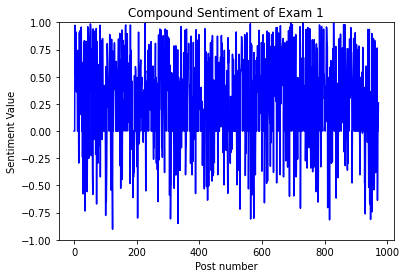

In [ ]:
plt.title("Compound Sentiment of Exam 1")
plt.plot(e1['compound'], color='blue')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

### Exam 2

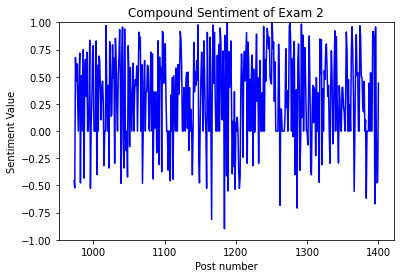

In [ ]:
plt.title("Compound Sentiment of Exam 2")
plt.plot(e2['compound'], color='blue')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

### Exam 3

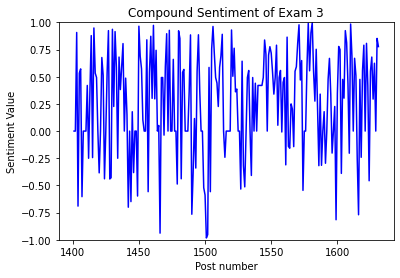

In [ ]:
plt.title("Compound Sentiment of Exam 3")
plt.plot(e3['compound'], color='blue')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

### Exam 4

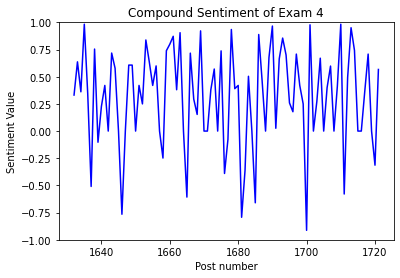

In [ ]:
plt.title("Compound Sentiment of Exam 4")
plt.plot(e4['compound'], color='blue')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

## Positive Sentiment Plots

### Exam 1

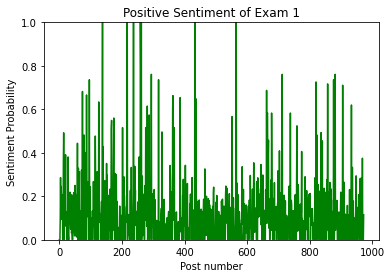

In [ ]:
plt.title("Positive Sentiment of Exam 1")
plt.plot(e1['pos'], color='green')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 2

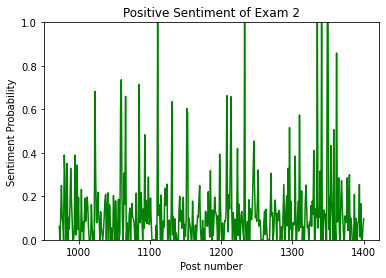

In [ ]:
plt.title("Positive Sentiment of Exam 2")
plt.plot(e2['pos'], color='green')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 3

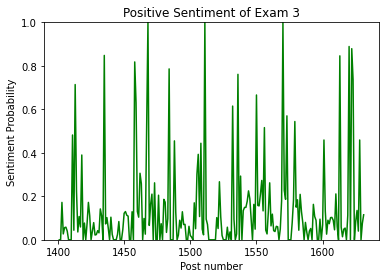

In [ ]:
plt.title("Positive Sentiment of Exam 3")
plt.plot(e3['pos'], color='green')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 4

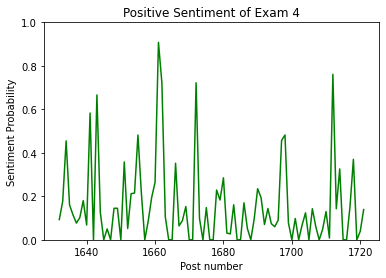

In [ ]:
plt.title("Positive Sentiment of Exam 4")
plt.plot(e4['pos'], color='green')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

## Negative Sentiment Plots

### Exam 1

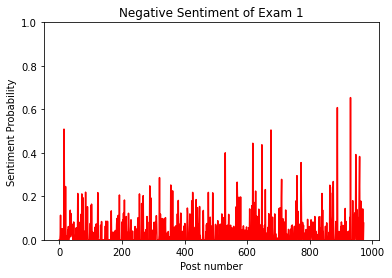

In [ ]:
plt.title("Negative Sentiment of Exam 1")
plt.plot(e1['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 2

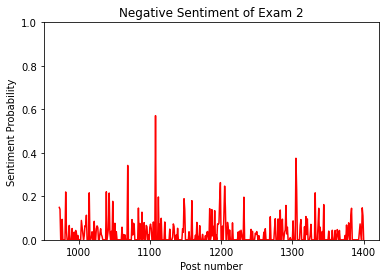

In [ ]:
plt.title("Negative Sentiment of Exam 2")
plt.plot(e2['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 3

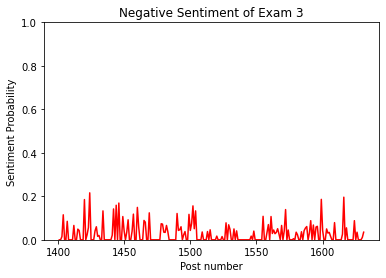

In [ ]:
plt.title("Negative Sentiment of Exam 3")
plt.plot(e3['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 4

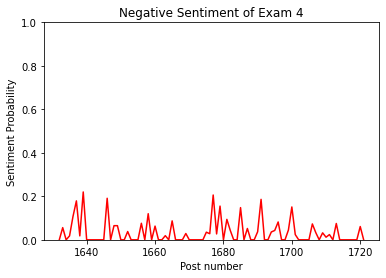

In [ ]:
plt.title("Negative Sentiment of Exam 4")
plt.plot(e4['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

## Positive v/s Negative Sentiment

### Exam 1

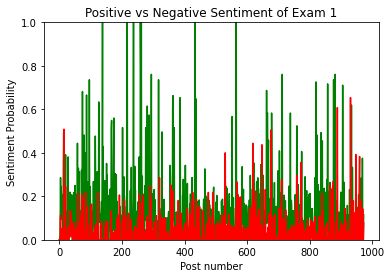

In [ ]:
plt.title("Positive vs Negative Sentiment of Exam 1")
plt.plot(e1['pos'], color='green')
plt.plot(e1['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 2

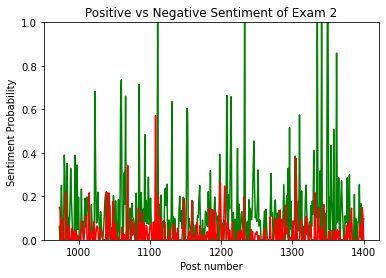

In [ ]:
plt.title("Positive vs Negative Sentiment of Exam 2")
plt.plot(e2['pos'], color='green')
plt.plot(e2['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 3

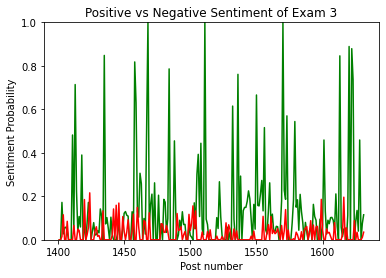

In [ ]:
plt.title("Positive vs Negative Sentiment of Exam 3")
plt.plot(e3['pos'], color='green')
plt.plot(e3['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

### Exam 4

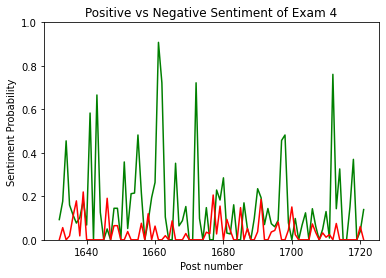

In [ ]:
plt.title("Positive vs Negative Sentiment of Exam 4")
plt.plot(e4['pos'], color='green')
plt.plot(e4['neg'], color='red')
plt.xlabel("Post number")
plt.ylabel("Sentiment Probability")
plt.ylim((0, 1))
plt.show()

## Count of all the 3 sentiments: pos, neg, neu

In [ ]:
# Generate the classes
sentiments = ['positive', 'negative', 'neutral']

### Exam 1

In [ ]:
# Exam 1
e1_classes = []
e1_count = [0]*3
for postve, negtve, neutral in zip(e1['pos'], e1['neg'], e1['neu']):
  postve = abs(postve)
  negtve = abs(negtve)
  neutral = abs(neutral)
  if postve > negtve and postve >= neutral:
    e1_classes.append(sentiments[0])
    e1_count[0] += 1
  elif negtve > postve and negtve >= neutral:
    e1_classes.append(sentiments[1])
    e1_count[1] += 1
  else:
    e1_classes.append(sentiments[2])
    e1_count[2] += 1
e1['sentiment'] = pd.DataFrame(e1_classes, index=[i for i in range(e1.index[0], e1.index[-1]+1)])

In [ ]:
e1

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound,sentiment
0,kcaz653v7u666u,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Search for Teammates!,"pa.load(""/dashboard/project_partners"", null, f...","Search for Teammates! pa.load(""/dashboard/proj...",0.000,1.000,0.000,0.0000,neutral
1,kcaz64zljpq66k,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Get familiar with Piazza,"pa.load(""/dashboard/get_familiar"", null, funct...","Get familiar with Piazza pa.load(""/dashboard/g...",0.000,1.000,0.000,0.0000,neutral
2,kcaz6506lfv66m,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Introduce Piazza to your students,"pa.load(""/dashboard/introduce_piazza"", null, f...","Introduce Piazza to your students pa.load(""/da...",0.000,1.000,0.000,0.0000,neutral
3,kcaz64xhuj166f,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Welcome to Piazza!,piazza is a q&a platform designed to get you g...,Welcome to Piazza! piazza is a q&a platform de...,0.022,0.888,0.091,0.9725,neutral
4,kcaz64z2b5w66i,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Tips & Tricks for a successful class,"pa.load(""/dashboard/tips_tricks"", null, functi...","Tips & Tricks for a successful class pa.load(""...",0.113,0.602,0.286,0.5106,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,kdumdwljhuc13k,j6f2j9crzay521,2020-08-14 19:23:57+00:00,followup,False,no,"wow, thank you! it worked. i was here trying t...",,"wow, thank you! it worked. i was here trying t...",0.000,0.625,0.375,0.7644,neutral
969,kdumy3zwkuy6o5,kccpr4483bi2k8,2020-08-14 19:39:40+00:00,followup,False,no,so i emailed the professor last night and call...,,so i emailed the professor last night and call...,0.142,0.812,0.046,-0.6361,neutral
970,kduoi76hgwy7n1,kccpr4483bi2k8,2020-08-14 20:23:17+00:00,followup,False,no,has anyone in this thread received a response ...,,has anyone in this thread received a response ...,0.000,1.000,0.000,0.0000,neutral
971,kduoj7fx1a6kz,k8gcb8lzg3x50j,2020-08-14 20:24:04+00:00,feedback,False,no,"nope, nothing.",,"nope, nothing.",0.000,1.000,0.000,0.0000,neutral


In [ ]:
# save the CSV
e1_final = pd.concat([e1['data_content'], e1['sentiment'], e1['pos'], e1['neg'], e1['neu']], axis=1)
e1_final.to_csv('Exam1Sentiments.csv', index=True, header=True)

### Exam 2

In [ ]:
# Exam 2
e2_classes = []
e2_count = [0]*3
for postve, negtve, neutral in zip(e2['pos'], e2['neg'], e2['neu']):
  postve = abs(postve)
  negtve = abs(negtve)
  neutral = abs(neutral)
  if postve > negtve and postve >= neutral:
    e2_classes.append(sentiments[0])
    e2_count[0] += 1
  elif negtve > postve and negtve >= neutral:
    e2_classes.append(sentiments[1])
    e2_count[1] += 1
  else:
    e2_classes.append(sentiments[2])
    e2_count[2] += 1
e2['sentiment'] = pd.DataFrame(e2_classes, index=[i for i in range(e2.index[0], e2.index[-1]+1)])

In [ ]:
# save the CSV
e2_final = pd.concat([e2['data_content'], e2['sentiment'], e2['pos'], e2['neg'], e2['neu']], axis=1)
e2_final.to_csv('Exam2Sentiments.csv', index=True, header=True)

### Exam 3

In [ ]:
# Exam 3
e3_classes = []
e3_count = [0]*3
for postve, negtve, neutral in zip(e3['pos'], e3['neg'], e3['neu']):
  postve = abs(postve)
  negtve = abs(negtve)
  neutral = abs(neutral)
  if postve > negtve and postve >= neutral:
    e3_classes.append(sentiments[0])
    e3_count[0] += 1
  elif negtve > postve and negtve >= neutral:
    e3_classes.append(sentiments[1])
    e3_count[1] += 1
  else:
    e3_classes.append(sentiments[2])
    e3_count[2] += 1
e3['sentiment'] = pd.DataFrame(e3_classes, index=[i for i in range(e3.index[0], e3.index[-1]+1)])

In [ ]:
# save the CSV
e3_final = pd.concat([e3['data_content'], e3['sentiment'], e3['pos'], e3['neg'], e3['neu']], axis=1)
e3_final.to_csv('Exam3Sentiments.csv', index=True, header=True)

### Exam 4

In [ ]:
# Exam 4
e4_classes = []
e4_count = [0]*3
for postve, negtve, neutral in zip(e4['pos'], e4['neg'], e4['neu']):
  postve = abs(postve)
  negtve = abs(negtve)
  neutral = abs(neutral)
  if postve > negtve and postve >= neutral:
    e4_classes.append(sentiments[0])
    e4_count[0] += 1
  elif negtve > postve and negtve >= neutral:
    e4_classes.append(sentiments[1])
    e4_count[1] += 1
  else:
    e4_classes.append(sentiments[2])
    e4_count[2] += 1
e4['sentiment'] = pd.DataFrame(e4_classes, index=[i for i in range(e4.index[0], e4.index[-1]+1)])

In [ ]:
# save the CSV
e4_final = pd.concat([e4['data_content'], e4['sentiment'], e4['pos'], e4['neg'], e4['neu']], axis=1)
e4_final.to_csv('Exam4Sentiments.csv', index=True, header=True)

### Plot of Sentiment Count of Piazza Posts by Exam Time Slice

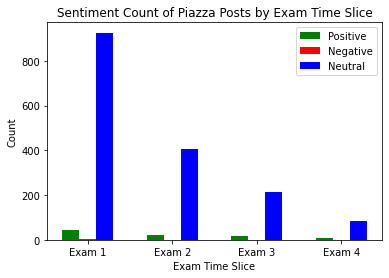

In [ ]:
# group bar chart
x = np.arange(4)
width = 0.2
plt.title("Sentiment Count of Piazza Posts by Exam Time Slice")
plt.bar(x-0.2, [e1_count[0], e2_count[0], e3_count[0], e4_count[0]], width, color='green')
plt.bar(x, [e1_count[1], e2_count[1], e3_count[1], e4_count[1]], width, color='red')
plt.bar(x+0.2, [e1_count[2], e2_count[2], e3_count[2], e4_count[2]], width, color='blue')
plt.xticks(x, ['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4'])
plt.xlabel("Exam Time Slice")
plt.ylabel("Count")
plt.legend(["Positive", "Negative", "Neutral"])
plt.show()

## Without considering neutral

### Exam 1

In [ ]:
# Exam 1
e1_classes_wout_neutral = []
e1_count_wout_neutral = [0]*2
for postve, negtve in zip(e1['pos'], e1['neg']):
  postve = abs(postve)
  negtve = abs(negtve)
  if postve > negtve:
    e1_classes_wout_neutral.append(sentiments[0])
    e1_count_wout_neutral[0] += 1
  else:
    e1_classes_wout_neutral.append(sentiments[1])
    e1_count_wout_neutral[1] += 1
e1['sentiment_wout_neutral'] = pd.DataFrame(e1_classes_wout_neutral, index=[i for i in range(e1.index[0], e1.index[-1]+1)])

In [ ]:
e1

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound,sentiment,sentiment_wout_neutral
0,kcaz653v7u666u,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Search for Teammates!,"pa.load(""/dashboard/project_partners"", null, f...","Search for Teammates! pa.load(""/dashboard/proj...",0.000,1.000,0.000,0.0000,neutral,negative
1,kcaz64zljpq66k,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Get familiar with Piazza,"pa.load(""/dashboard/get_familiar"", null, funct...","Get familiar with Piazza pa.load(""/dashboard/g...",0.000,1.000,0.000,0.0000,neutral,negative
2,kcaz6506lfv66m,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Introduce Piazza to your students,"pa.load(""/dashboard/introduce_piazza"", null, f...","Introduce Piazza to your students pa.load(""/da...",0.000,1.000,0.000,0.0000,neutral,negative
3,kcaz64xhuj166f,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Welcome to Piazza!,piazza is a q&a platform designed to get you g...,Welcome to Piazza! piazza is a q&a platform de...,0.022,0.888,0.091,0.9725,neutral,positive
4,kcaz64z2b5w66i,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Tips & Tricks for a successful class,"pa.load(""/dashboard/tips_tricks"", null, functi...","Tips & Tricks for a successful class pa.load(""...",0.113,0.602,0.286,0.5106,neutral,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,kdumdwljhuc13k,j6f2j9crzay521,2020-08-14 19:23:57+00:00,followup,False,no,"wow, thank you! it worked. i was here trying t...",,"wow, thank you! it worked. i was here trying t...",0.000,0.625,0.375,0.7644,neutral,positive
969,kdumy3zwkuy6o5,kccpr4483bi2k8,2020-08-14 19:39:40+00:00,followup,False,no,so i emailed the professor last night and call...,,so i emailed the professor last night and call...,0.142,0.812,0.046,-0.6361,neutral,negative
970,kduoi76hgwy7n1,kccpr4483bi2k8,2020-08-14 20:23:17+00:00,followup,False,no,has anyone in this thread received a response ...,,has anyone in this thread received a response ...,0.000,1.000,0.000,0.0000,neutral,negative
971,kduoj7fx1a6kz,k8gcb8lzg3x50j,2020-08-14 20:24:04+00:00,feedback,False,no,"nope, nothing.",,"nope, nothing.",0.000,1.000,0.000,0.0000,neutral,negative


In [ ]:
# save the CSV
e1_final_wout_neutral = pd.concat([e1['data_content'], e1['sentiment_wout_neutral'], e1['pos'], e1['neg'], e1['neu']], axis=1)
e1_final_wout_neutral.to_csv('Exam1SentimentsWoutNeutral.csv', index=True, header=True)

### Exam 2

In [ ]:
# Exam 2
e2_classes_wout_neutral = []
e2_count_wout_neutral = [0]*2
for postve, negtve in zip(e2['pos'], e2['neg']):
  postve = abs(postve)
  negtve = abs(negtve)
  if postve > negtve:
    e2_classes_wout_neutral.append(sentiments[0])
    e2_count_wout_neutral[0] += 1
  else:
    e2_classes_wout_neutral.append(sentiments[1])
    e2_count_wout_neutral[1] += 1
e2['sentiment_wout_neutral'] = pd.DataFrame(e2_classes_wout_neutral, index=[i for i in range(e2.index[0], e2.index[-1]+1)])

In [ ]:
# save the CSV
e2_final_wout_neutral = pd.concat([e2['data_content'], e2['sentiment_wout_neutral'], e2['pos'], e2['neg'], e2['neu']], axis=1)
e2_final_wout_neutral.to_csv('Exam2SentimentsWoutNeutral.csv', index=True, header=True)

### Exam 3

In [ ]:
# Exam 3
e3_classes_wout_neutral = []
e3_count_wout_neutral = [0]*2
for postve, negtve in zip(e3['pos'], e3['neg']):
  postve = abs(postve)
  negtve = abs(negtve)
  if postve > negtve:
    e3_classes_wout_neutral.append(sentiments[0])
    e3_count_wout_neutral[0] += 1
  else:
    e3_classes_wout_neutral.append(sentiments[1])
    e3_count_wout_neutral[1] += 1
e3['sentiment_wout_neutral'] = pd.DataFrame(e3_classes_wout_neutral, index=[i for i in range(e3.index[0], e3.index[-1]+1)])

In [ ]:
# save the CSV
e3_final_wout_neutral = pd.concat([e3['data_content'], e3['sentiment_wout_neutral'], e3['pos'], e3['neg'], e3['neu']], axis=1)
e3_final_wout_neutral.to_csv('Exam3SentimentsWoutNeutral.csv', index=True, header=True)

### Exam 4

In [ ]:
# Exam 4
e4_classes_wout_neutral = []
e4_count_wout_neutral = [0]*2
for postve, negtve in zip(e4['pos'], e4['neg']):
  postve = abs(postve)
  negtve = abs(negtve)
  if postve > negtve:
    e4_classes_wout_neutral.append(sentiments[0])
    e4_count_wout_neutral[0] += 1
  else:
    e4_classes_wout_neutral.append(sentiments[1])
    e4_count_wout_neutral[1] += 1
e4['sentiment_wout_neutral'] = pd.DataFrame(e4_classes_wout_neutral, index=[i for i in range(e4.index[0], e4.index[-1]+1)])

In [ ]:
# save the CSV
e4_final_wout_neutral = pd.concat([e4['data_content'], e4['sentiment_wout_neutral'], e4['pos'], e4['neg'], e4['neu']], axis=1)
e4_final_wout_neutral.to_csv('Exam4SentimentsWoutNeutral.csv', index=True, header=True)

In [ ]:
e2

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound,sentiment,sentiment_wout_neutral
973,kduxl6hplm219r,kccpre6co5x2yz,2020-08-15 00:37:33+00:00,feedback,False,stud,we should email professor about the incident a...,,we should email professor about the incident a...,0.149,0.789,0.061,-0.4588,neutral,negative
974,kduxvift38t3sp,kccpr4483bi2k8,2020-08-15 00:45:35+00:00,feedback,False,no,i emailed him last night and still have no res...,,i emailed him last night and still have no res...,0.140,0.860,0.000,-0.5234,neutral,negative
975,kdv22grhfhs39c,kccomqtx7x04i,2020-08-15 02:42:58+00:00,post,False,no,"In gradescope, do we need to tag a page as &#3...",since our hw 5 extra credit question is techni...,"In gradescope, do we need to tag a page as &#3...",0.000,0.890,0.110,0.6767,neutral,positive
976,kdv728l6bb12ys,kccpr4483bi2k8,2020-08-15 05:02:45+00:00,feedback,False,no,please do not mark this as resolved again as i...,,please do not mark this as resolved again as i...,0.000,0.750,0.250,0.4588,neutral,positive
977,kdv7kktgm1827g,jqjrav14ehv5px,2020-08-15 05:17:01+00:00,feedback,False,no,i'm not sure who marked that as resolved but i...,,i'm not sure who marked that as resolved but i...,0.094,0.801,0.105,0.6193,neutral,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,kfhl1r19nrmpu,kccoo5w5r2v73o,2020-09-25 01:44:55+00:00,post,False,no,Exam Submitted On Time,is it possible to know if we submitted the exa...,Exam Submitted On Time is it possible to know ...,0.030,0.804,0.166,0.9577,neutral,positive
1397,kfhekf7v25o78q,kccprf6rrwo30e,2020-09-25 03:56:53+00:00,post,False,no,ProctorU won&#39;t met me take the test,"due to technical issues, proctoru won't let me...",ProctorU won&#39;t met me take the test due to...,0.000,1.000,0.000,0.0000,neutral,negative
1398,kfhrv051xts52z,kccpr6hveyd2ng,2020-09-25 04:55:38+00:00,post,False,no,Wrong exam in proctorU,the exam has a different name then the one i a...,Wrong exam in proctorU the exam has a differen...,0.147,0.853,0.000,-0.4767,neutral,negative
1399,kfils08c3ffnx,kccpr2zaayq2i8,2020-09-25 18:53:06+00:00,post,False,no,Exam 2,"i noticed that for my exam code yesterday, i a...",Exam 2 i noticed that for my exam code yesterd...,0.110,0.833,0.057,-0.4606,neutral,negative


In [ ]:
e3

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound,sentiment,sentiment_wout_neutral
1401,kfj0o01ihzh7lc,kccpra35bd92s8,2020-09-26 01:49:54+00:00,followup,False,no,is the webinar tomorrow at 9:30?,,is the webinar tomorrow at 9:30?,0.000,1.000,0.000,0.0000,neutral,negative
1402,kfj48yqrnu923k,kccpr533qtr2lf,2020-09-26 03:30:11+00:00,feedback,False,no,i think it is on next thursday 8:00 pm,,i think it is on next thursday 8:00 pm,0.000,1.000,0.000,0.0000,neutral,negative
1403,kfjwidp7dj428d,kccpr35mpc12ig,2020-09-26 16:41:19+00:00,post,False,no,Re-take EXAM 2,"hello professor, i would really like to take e...","Re-take EXAM 2 hello professor, i would really...",0.015,0.812,0.172,0.9069,neutral,positive
1404,kfjwm6211ts3t5,kccpr35mpc12ig,2020-09-26 16:44:16+00:00,post,False,stud,Re-Open EXAM 2,"professor, would you be able to re-open exam 2...","Re-Open EXAM 2 professor, would you be able to...",0.115,0.858,0.027,-0.6901,neutral,negative
1405,kfk2c5jzcfi23p,kccpr3yu44w2jw,2020-09-26 19:25:09+00:00,post,False,no,Module 15 - Typo or some kind of C&#43;&#43; n...,"in module 15, section 'accessors and mutators'...",Module 15 - Typo or some kind of C&#43;&#43; n...,0.000,0.944,0.056,0.5330,neutral,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,khfkh7z8e9d46l,kccprco99ch2vn,2020-11-13 01:12:50+00:00,post,False,no,Couldn&#39;t find classes when submitting,"hello, i've submitted my exam through gradesco...",Couldn&#39;t find classes when submitting hell...,0.000,0.960,0.040,0.2942,neutral,positive
1628,khfs3pbkvf2qz,kccpraydebv2te,2020-11-13 04:46:16+00:00,followup,False,no,"oops, i only submitted via gradescope! i hope ...",,"oops, i only submitted via gradescope! i hope ...",0.000,0.541,0.459,0.6239,neutral,positive
1629,khgdqgv2yua2dq,kccprhv31vd33l,2020-11-13 14:51:50+00:00,post,False,no,Homework Not Posted Yet?,"hello, i know we had an exam last night, but w...","Homework Not Posted Yet? hello, i know we had ...",0.000,1.000,0.000,0.0000,neutral,negative
1630,khgkjoflihy66v,kccpr9qwli32rt,2020-11-13 18:02:30+00:00,post,False,no,HW17 - Extent to Which Changing Provided Code ...,"hi tas, quick question about homework 17, reg...",HW17 - Extent to Which Changing Provided Code ...,0.011,0.914,0.075,0.8523,neutral,positive


In [ ]:
e4

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound,sentiment,sentiment_wout_neutral
1632,khkbq1tuena3x4,kccprc5trdb2uv,2020-11-16 09:06:36+00:00,post,False,no,Resubmit HW 17?,"since it's an off week (for homework), is ther...",Resubmit HW 17? since it's an off week (for ho...,0.000,0.907,0.093,0.3313,neutral,positive
1633,khl87tc0kqw6yd,kccprfql4pw318,2020-11-17 00:16:12+00:00,post,False,no,hw16-Q1 test cases,"hi, i saw that the grade for hw16 is posted an...","hw16-Q1 test cases hi, i saw that the grade fo...",0.056,0.767,0.177,0.6369,neutral,positive
1634,khmqpcfsbe956a,kccprfql4pw318,2020-11-18 01:41:30+00:00,followup,False,no,"will do, thank you.",,"will do, thank you.",0.000,0.545,0.455,0.3612,neutral,positive
1635,khnhpx6evh04j1,gd6v7134AUa,2020-11-18 14:17:46+00:00,post,False,no,Enhanced Polls Functionality,"with feedback from instructors, we have enhanc...",Enhanced Polls Functionality with feedback fro...,0.018,0.822,0.160,0.9831,neutral,positive
1636,khno7bg7rbv7b6,k54tl8fv6s767g,2020-11-18 17:19:15+00:00,post,False,stud,Module 23 processes and threads,"there is a slide in module 23 that says ""does ...",Module 23 processes and threads there is a sli...,0.107,0.778,0.115,0.3436,neutral,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,kiqxbveidci4xm,k54tq3hzuyo33f,2020-12-16 04:37:45+00:00,feedback,False,no,"i don't know, that seems like a logical conclu...",,"i don't know, that seems like a logical conclu...",0.000,0.848,0.152,0.3612,neutral,positive
1718,kirc9jcvei11tr,kccpr58wnwl2lm,2020-12-16 11:35:51+00:00,followup,False,no,"ian, thank you so much for this answer! it is ...",,"ian, thank you so much for this answer! it is ...",0.000,0.630,0.370,0.7082,neutral,positive
1719,kitg7eg1kr12m4,kccpicp8wjt60n,2020-12-17 23:01:42+00:00,post,False,stud,Exam 4 Gradescope Link,is exam 4 going to be added to gradescope?,Exam 4 Gradescope Link is exam 4 going to be a...,0.000,1.000,0.000,0.0000,neutral,negative
1720,kitkll8lc9f624,kccop9yg5w7li,2020-12-18 01:04:42+00:00,post,False,no,confirming submission/complete exam,"hello all, i just finished my exam but proctor...","confirming submission/complete exam hello all,...",0.061,0.900,0.039,-0.3137,neutral,negative


### Plot of Sentiment Count of Piazza Posts by Exam Time Slice W/out considering Neutral

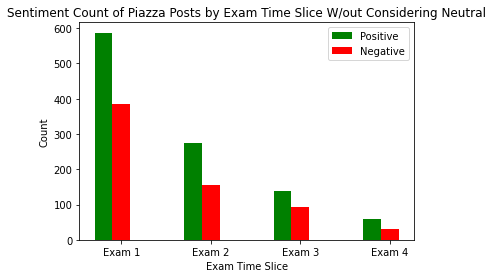

In [ ]:
# group bar chart
x = np.arange(4)
width = 0.2
plt.title("Sentiment Count of Piazza Posts by Exam Time Slice W/out Considering Neutral")
plt.bar(x-0.2, [e1_count_wout_neutral[0], e2_count_wout_neutral[0], e3_count_wout_neutral[0], e4_count_wout_neutral[0]], width, color='green')
plt.bar(x, [e1_count_wout_neutral[1], e2_count_wout_neutral[1], e3_count_wout_neutral[1], e4_count_wout_neutral[1]], width, color='red')
plt.xticks(x, ['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4'])
plt.xlabel("Exam Time Slice")
plt.ylabel("Count")
plt.legend(["Positive", "Negative"])
plt.show()

### Plot of Sentiment Fraction of Piazza Posts by Exam Time Slice W/out Considering Neutral

In [ ]:
e1_fractions = [0]*2
e1_fractions[0] = e1_count_wout_neutral[0]/sum(e1_count_wout_neutral)
e1_fractions[1] = e1_count_wout_neutral[1]/sum(e1_count_wout_neutral)

In [ ]:
e2_fractions = [0]*2
e2_fractions[0] = e2_count_wout_neutral[0]/sum(e2_count_wout_neutral)
e2_fractions[1] = e2_count_wout_neutral[1]/sum(e2_count_wout_neutral)

In [ ]:
e3_fractions = [0]*2
e3_fractions[0] = e3_count_wout_neutral[0]/sum(e3_count_wout_neutral)
e3_fractions[1] = e3_count_wout_neutral[1]/sum(e3_count_wout_neutral)

In [ ]:
e4_fractions = [0]*2
e4_fractions[0] = e4_count_wout_neutral[0]/sum(e4_count_wout_neutral)
e4_fractions[1] = e4_count_wout_neutral[1]/sum(e4_count_wout_neutral)

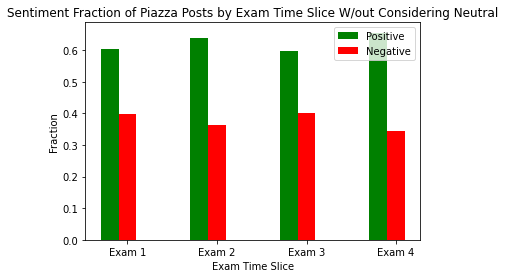

In [ ]:
# group bar chart
x = np.arange(4)
width = 0.2
plt.title("Sentiment Fraction of Piazza Posts by Exam Time Slice W/out Considering Neutral")
plt.bar(x-0.2, [e1_fractions[0], e2_fractions[0], e3_fractions[0], e4_fractions[0]], width, color='green')
plt.bar(x, [e1_fractions[1], e2_fractions[1], e3_fractions[1], e4_fractions[1]], width, color='red')
plt.xticks(x, ['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4'])
plt.xlabel("Exam Time Slice")
plt.ylabel("Fraction")
plt.legend(["Positive", "Negative"])
plt.show()

### Plot of Neutral Sentiment Fraction of Piazza Posts by Exam Time Slice

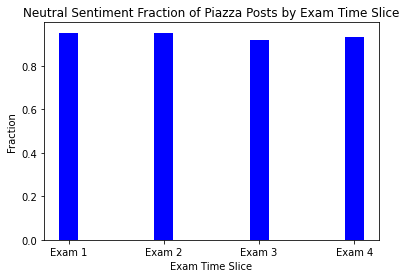

In [ ]:
# group bar chart
x = np.arange(4)
plt.title("Neutral Sentiment Fraction of Piazza Posts by Exam Time Slice")
plt.bar(x, [e1_count[2]/sum(e1_count), e2_count[2]/sum(e2_count), e3_count[2]/sum(e3_count), e4_count[2]/sum(e4_count)], width, color='blue')
plt.xticks(x, ['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4'])
plt.xlabel("Exam Time Slice")
plt.ylabel("Fraction")
plt.show()

As we come to know that the neutral sentiment fraction of posts is the same for every exam time slice, it is safe to say that our hypothesis that the positive sentiment decreases with time and the negative sentiment increases with time. Although, in our case, there is almost a plateau of negative sentiments after exam 2 time slice.

### Final CSV file combining all the exam time slices

In [ ]:
# combine all the four exam time slices
piazzaPostsWithSentiments = pd.concat([e1, e2, e3, e4], axis=0)
piazzaPostsWithSentiments

,unique_id,uid,created,type,is_instructor,anon,subject,content,data_content,neg,neu,pos,compound,sentiment,sentiment_wout_neutral
0,kcaz653v7u666u,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Search for Teammates!,"pa.load(""/dashboard/project_partners"", null, f...","Search for Teammates! pa.load(""/dashboard/proj...",0.000,1.000,0.000,0.0000,neutral,negative
1,kcaz64zljpq66k,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Get familiar with Piazza,"pa.load(""/dashboard/get_familiar"", null, funct...","Get familiar with Piazza pa.load(""/dashboard/g...",0.000,1.000,0.000,0.0000,neutral,negative
2,kcaz6506lfv66m,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Introduce Piazza to your students,"pa.load(""/dashboard/introduce_piazza"", null, f...","Introduce Piazza to your students pa.load(""/da...",0.000,1.000,0.000,0.0000,neutral,negative
3,kcaz64xhuj166f,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Welcome to Piazza!,piazza is a q&a platform designed to get you g...,Welcome to Piazza! piazza is a q&a platform de...,0.022,0.888,0.091,0.9725,neutral,positive
4,kcaz64z2b5w66i,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Tips & Tricks for a successful class,"pa.load(""/dashboard/tips_tricks"", null, functi...","Tips & Tricks for a successful class pa.load(""...",0.113,0.602,0.286,0.5106,neutral,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,kiqxbveidci4xm,k54tq3hzuyo33f,2020-12-16 04:37:45+00:00,feedback,False,no,"i don't know, that seems like a logical conclu...",,"i don't know, that seems like a logical conclu...",0.000,0.848,0.152,0.3612,neutral,positive
1718,kirc9jcvei11tr,kccpr58wnwl2lm,2020-12-16 11:35:51+00:00,followup,False,no,"ian, thank you so much for this answer! it is ...",,"ian, thank you so much for this answer! it is ...",0.000,0.630,0.370,0.7082,neutral,positive
1719,kitg7eg1kr12m4,kccpicp8wjt60n,2020-12-17 23:01:42+00:00,post,False,stud,Exam 4 Gradescope Link,is exam 4 going to be added to gradescope?,Exam 4 Gradescope Link is exam 4 going to be a...,0.000,1.000,0.000,0.0000,neutral,negative
1720,kitkll8lc9f624,kccop9yg5w7li,2020-12-18 01:04:42+00:00,post,False,no,confirming submission/complete exam,"hello all, i just finished my exam but proctor...","confirming submission/complete exam hello all,...",0.061,0.900,0.039,-0.3137,neutral,negative


In [ ]:
# save the CSV
piazzaPostsWithSentiments.to_csv('piazzaPostsWithSentiments.csv', index=True, header=True)

# Package Used: TextBlob

Only one sentiment is calculated here, **polarity**. Polarity is basically the sum of the positive and negative sentiment normalized between [-1, 1] where, -1 is extreme negative sentiment and +1 is extreme positive sentiment.

One of the other applications of using TextBlob is to calculate whether the text is subjective or objective. However, in this context, we do not need the information of whether the post is more subjective or objective. Hence, we can ignore this functionality of TextBlob.

In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora

Requirement already up-to-date: textblob in /usr/local/lib/python3.7/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from textblob import TextBlob

In [ ]:
# Exam 1 Polarity
e1_polarity = []
for sentence in e1['data_content']:
  e1_blob = TextBlob(sentence)
  e1_polarity.append(e1_blob.sentiment.polarity)

In [ ]:
# Exam 2 Polarity
e2_polarity = []
for sentence in e2['data_content']:
  e2_blob = TextBlob(str(sentence))
  e2_polarity.append(e2_blob.sentiment.polarity)

In [ ]:
# Exam 3 Polarity
e3_polarity = []
for sentence in e3['data_content']:
  e3_blob = TextBlob(str(sentence))
  e3_polarity.append(e3_blob.sentiment.polarity)

In [ ]:
# Exam 4 Polarity
e4_polarity = []
for sentence in e4['data_content']:
  e4_blob = TextBlob(str(sentence))
  e4_polarity.append(e4_blob.sentiment.polarity)

## Plotting the polarity

### Exam 1

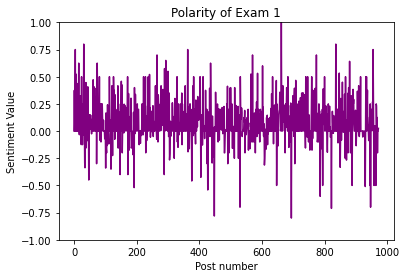

In [ ]:
plt.title("Polarity of Exam 1")
plt.plot(e1_polarity, color='purple')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

### Exam 2

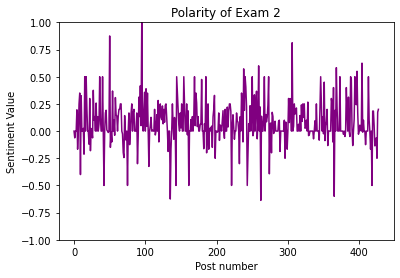

In [ ]:
plt.title("Polarity of Exam 2")
plt.plot(e2_polarity, color='purple')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

### Exam 3

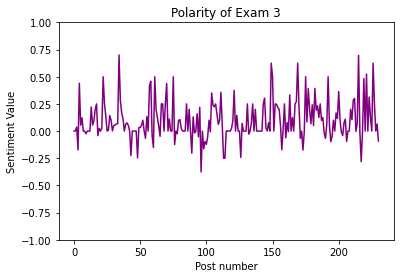

In [ ]:
plt.title("Polarity of Exam 3")
plt.plot(e3_polarity, color='purple')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()

### Exam 4

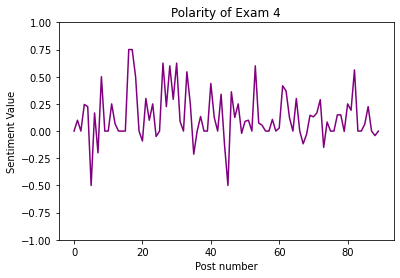

In [ ]:
plt.title("Polarity of Exam 4")
plt.plot(e4_polarity, color='purple')
plt.xlabel("Post number")
plt.ylabel("Sentiment Value")
plt.ylim((-1, 1))
plt.show()